In [0]:
# I use Google Colab for this one

# Install all general packages
!pip install numpy scipy scikit-learn matplotlib pandas pillow graphviz scikit-image
!pip install ipywidgets

# Graphviz system level
!apt-get install -y graphviz

# OpenML
!pip install git+https://github.com/renatopp/liac-arff@master
!pip install git+https://github.com/openml/openml-python.git@develop

# Getting directory
!if [ ! -d ML-course ]; then git clone https://github.com/joaquinvanschoren/ML-course.git; else echo "Repo already cloned"; fi;
!cp -r ML-course/* .


# Foundations of Data Mining: Fashion-MNIST Challenge

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [0]:
# Please fill in your names here
NAME_STUDENT_1 = "J. Gómez Robles"

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 200 # This controls the size of your figures
plt.rcParams['savefig.dpi'] = 200 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all" 
import sklearn.decomposition as deco
from sklearn.cluster import KMeans 
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


Using TensorFlow backend.


## Fashion-MNIST
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [0]:
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [0]:
fmnist_data = oml.datasets.get_dataset(40996) # Download MNIST data
# Get the predictors X and the labels y
X, y = fmnist_data.get_data(target=fmnist_data.default_target_attribute); 

In [0]:
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a = fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize = 6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return
  
# build a list of figures for plotting
def buildNCList(fig, subfiglist, titles, length):
    
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((8, 8))
        a = fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize=6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

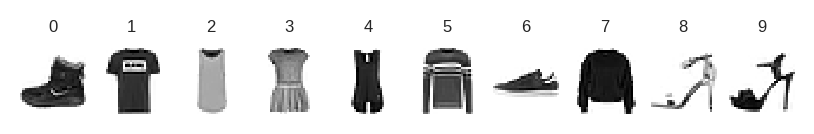

In [7]:
subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X[i])
    titles.append(i)

buildFigureList(plt.figure(1),subfiglist, titles, 10)
plt.show()

## Question 2. Analyzing image data with neural embedding

*In this part of the assignment, rather than working on the whole dataset you will implement representation learning on one part of the data and analyze the second part of the data with the learned representations.*

Use the provided code to split the training dataset in two subset based on their class labels. Dataset 1, containing classes 0 to 4 and Dataset 2 classes 5 to 9. 

### a ) Develop a model for learning representations (4 points)

Develop a convolutional neural network model for classification on Dataset 1 using the Keras python library.

You are free to choose your model architecture such that:
- You need to justify the decisions for selecting the layers, activation functions and loss function. (Add a text cell where you can write your justification)
- Your model must have one dense layer with 64 neurons and ReLU activation that is not the first nor the last layer in the model. We will refer to this layer as a 'neural code' (set **name='neural_codes'** parameter in your code for that layer).


In [8]:
## Do not modify this cell
# Load and reshape the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

x_train = X
y_train = y

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    #x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

    y_train = to_categorical(y_train, n_classes)

    
# Split the train data in two datasets 
indexes1 = np.where(np.argmax(y_train, axis=1) <= 4)
indexes2 = np.where(np.argmax(y_train, axis=1) > 4)
dataset_1 = x_train[indexes1]
y_dataset1 = y_train[indexes1]
dataset_2 = x_train[indexes2]
y_dataset2 = y_train[indexes2]

print ("Dataset 1 shape: ", dataset_1.shape)    
print ("Dataset 2 shape: ", dataset_2.shape)    
print("Dataset 1 labels shape: ", y_dataset1.shape)
print("Dataset 2 labels shape: ", y_dataset2.shape)


Dataset 1 shape:  (35000, 28, 28, 1)
Dataset 2 shape:  (35000, 28, 28, 1)
Dataset 1 labels shape:  (35000, 10)
Dataset 2 labels shape:  (35000, 10)


In [0]:
# Get the datesets with the right categories (only 5 per dataset)
y_dataset1_fixed = y_dataset1[:, :5]
y_dataset2_fixed = y_dataset2[:, 5:]

In [10]:
# Implement your model here
n_labelled_classes = 5
n_last_dense = 64

model = Sequential()

# === SOLUTION: ===

# filters: feature maps (the 3rd dimension)
# kernel_size: mask
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = input_shape, 
               activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# As per requirements
model.add(Dense(n_last_dense, activation='relu', name = "neural_codes"))
model.add(Dropout(0.5))

model.add(Dense(n_labelled_classes, activation='softmax'))

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

**Justification**

For this task we decided to implement a typical CNN architecture where, for the Convolutional part, at each layer the size of the feature maps would increase (`32 -> 64`). The base architecture is:

- Layer 1.1 (Convolution + MaxPooling): 32 feature maps, kernel of 3x3 and no strides.
- Layer 1.2: Dropout of 25%. Avoids oferfitting and improves computational time.
- Layer 2.1 (Convolution + MaxPooling): 64 feature maps, kernel of 3x3 and no strides. This layer improved the computational time of the CNN.
- Layer 2.2: Dropout of 25%. Avoids oferfitting and improves computational time.
- Layer 3.1 (Dense): The `neural_codes` layer as requested.
- Layer 3.2: Dropout of 50%. Avoids oferfitting and improves computational time.
- Output layer: Softmax providing estimated probability for each of the 5 classes.



In [0]:
# Do not modify this cell
# Execute this cell before training!
# This is the model for extracting the image neural codes from the trained model
neural_codes_model = Model(inputs=model.input, outputs=model.get_layer("neural_codes").output)

In [12]:
# Trainning loop 
# given parameters are just a suggestion
batch_size = 64
epochs = 10

model.fit(dataset_1, y_dataset1_fixed,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 9s 290us/step - loss: 2.7131 - acc: 0.6099 - val_loss: 0.5034 - val_acc: 0.8143
Epoch 2/10
31500/31500 [==============================] - 7s 235us/step - loss: 0.5594 - acc: 0.7806 - val_loss: 0.3777 - val_acc: 0.8474
Epoch 3/10
26752/31500 [========================>.....] - ETA: 1s - loss: 0.4680 - acc: 0.8226

31500/31500 [==============================] - 7s 237us/step - loss: 0.4616 - acc: 0.8252 - val_loss: 0.3408 - val_acc: 0.8709
Epoch 4/10
31500/31500 [==============================] - 7s 235us/step - loss: 0.4118 - acc: 0.8456 - val_loss: 0.3084 - val_acc: 0.8920
Epoch 5/10
31500/31500 [==============================] - 7s 234us/step - loss: 0.3820 - acc: 0.8587 - val_loss: 0.2924 - val_acc: 0.8960
Epoch 6/10
11776/31500 [==========>...................] - ETA: 4s - loss: 0.3692 - acc: 0.8641

31500/31500 [==============================] - 7s 238us/step - loss: 0.3635 - acc: 0.8667 - val_loss: 0.2885 - val_acc: 0.8963
Epoch 7/10
31500/31500 [==============================] - 7s 233us/step - loss: 0.3424 - acc: 0.8764 - val_loss: 0.2757 - val_acc: 0.9031
Epoch 8/10
31500/31500 [==============================] - 7s 234us/step - loss: 0.3311 - acc: 0.8815 - val_loss: 0.2647 - val_acc: 0.9020
Epoch 9/10
 9728/31500 [========>.....................] - ETA: 4s - loss: 0.3230 - acc: 0.8834

31500/31500 [==============================] - 7s 234us/step - loss: 0.3142 - acc: 0.8859 - val_loss: 0.2585 - val_acc: 0.9131
Epoch 10/10
31500/31500 [==============================] - 7s 235us/step - loss: 0.3050 - acc: 0.8896 - val_loss: 0.2499 - val_acc: 0.9143



### b) Generate neural codes (1 point) 
Process all the images from Data set 2 with the trained model from **a)** and save the activations from the 'neural code' layer 

In [0]:
# Implement here
# Note: Using neural_codes_model compute the neural code for the images in dataset_2 

neural_codes = neural_codes_model.predict(dataset_2)

### c) Analyze the neural codes (3 points) 

Implement the following analysis of the neural codes computed in ** b) **:

- Compute and show the mean and the first two principle components as images (see note below)
- Make a 2-dimensional scatter plot of the transformed data
- Compute and show a small number of samples along each of the two main axes as images
- Compare the results of this analysis with the results of the analysis in part one where you worked on the data in the high dimensional (image) space. 

*Note: To produce an image from a arbitrary neural code use nearest neighbor to find the closest neural code from the training dataset (code is provided in the next cell)* 

In [20]:
# Do not modify this cell
# This code will give you a method for getting the index of the closest neural code neighbor 
# (see example code in the next cell)
neigh = NearestNeighbors(n_neighbors = 5, p=2)
neigh.fit(neural_codes)

def get_closest_neighbor(code):
    distances, indexes = neigh.kneighbors([code])
    return indexes[0, 1]


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

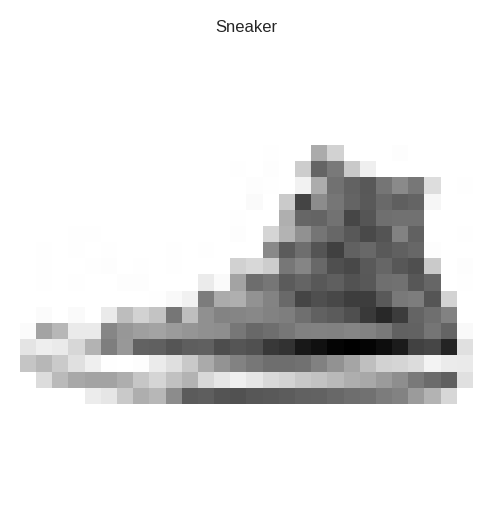

In [15]:
# Compute and show the mean of the neural codes
mean_neural_code = np.mean(neural_codes, axis = 0)

index_mean_neighbor = get_closest_neighbor(mean_neural_code)

subfiglist = []
titles = []
subfiglist.append(np.squeeze(dataset_2[index_mean_neighbor], axis=2))
titles.append(fmnist_classes[np.argmax(y_dataset2[index_mean_neighbor])])

buildFigureList(plt.figure(1), subfiglist, titles, 1)

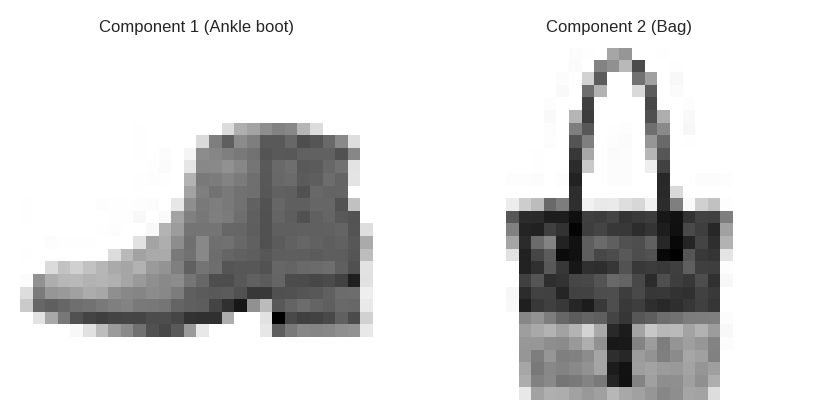

In [23]:
# Compute and show the first two principle components as images (see note below)

pca = PCA(n_components = 2)
pca_fit = pca.fit(neural_codes) 
pca_projected = pca.transform(neural_codes)

principal_components = pca_fit.components_

subfiglist = []
titles = []

for i, component in enumerate(principal_components):
  index_mean_neighbor = get_closest_neighbor(component)
  subfiglist.append(np.squeeze(dataset_2[index_mean_neighbor], axis=2))
  titles.append("Component {} ({})".format(i+1, fmnist_classes[np.argmax(y_dataset2[index_mean_neighbor])]) )

buildFigureList(plt.figure(1), subfiglist, titles, 2)

Text(5,2,'(-36.39,\n-6.99)')

Text(5,2,'(-36.39,\n0.00)')

Text(5,2,'(-36.39,\n5.50)')

Text(5,2,'(-36.39,\n17.98)')

Text(5,2,'(-36.39,\n30.46)')

Text(5,2,'(-36.39,\n42.95)')

Text(5,2,'(-36.39,\n55.43)')

Text(5,2,'(-14.15,\n-6.99)')

Text(5,2,'(-14.15,\n0.00)')

Text(5,2,'(-14.15,\n5.50)')

Text(5,2,'(-14.15,\n17.98)')

Text(5,2,'(-14.15,\n30.46)')

Text(5,2,'(-14.15,\n42.95)')

Text(5,2,'(-14.15,\n55.43)')

Text(5,2,'(0.00,\n-6.99)')

Text(5,2,'(0.00,\n0.00)')

Text(5,2,'(0.00,\n5.50)')

Text(5,2,'(0.00,\n17.98)')

Text(5,2,'(0.00,\n30.46)')

Text(5,2,'(0.00,\n42.95)')

Text(5,2,'(0.00,\n55.43)')

Text(5,2,'(8.10,\n-6.99)')

Text(5,2,'(8.10,\n0.00)')

Text(5,2,'(8.10,\n5.50)')

Text(5,2,'(8.10,\n17.98)')

Text(5,2,'(8.10,\n30.46)')

Text(5,2,'(8.10,\n42.95)')

Text(5,2,'(8.10,\n55.43)')

Text(5,2,'(30.35,\n-6.99)')

Text(5,2,'(30.35,\n0.00)')

Text(5,2,'(30.35,\n5.50)')

Text(5,2,'(30.35,\n17.98)')

Text(5,2,'(30.35,\n30.46)')

Text(5,2,'(30.35,\n42.95)')

Text(5,2,'(30.35,\n55.43)')

Text(5,2,'(52.60,\n-6.99)')

Text(5,2,'(52.60,\n0.00)')

Text(5,2,'(52.60,\n5.50)')

Text(5,2,'(52.60,\n17.98)')

Text(5,2,'(52.60,\n30.46)')

Text(5,2,'(52.60,\n42.95)')

Text(5,2,'(52.60,\n55.43)')

Text(5,2,'(74.84,\n-6.99)')

Text(5,2,'(74.84,\n0.00)')

Text(5,2,'(74.84,\n5.50)')

Text(5,2,'(74.84,\n17.98)')

Text(5,2,'(74.84,\n30.46)')

Text(5,2,'(74.84,\n42.95)')

Text(5,2,'(74.84,\n55.43)')

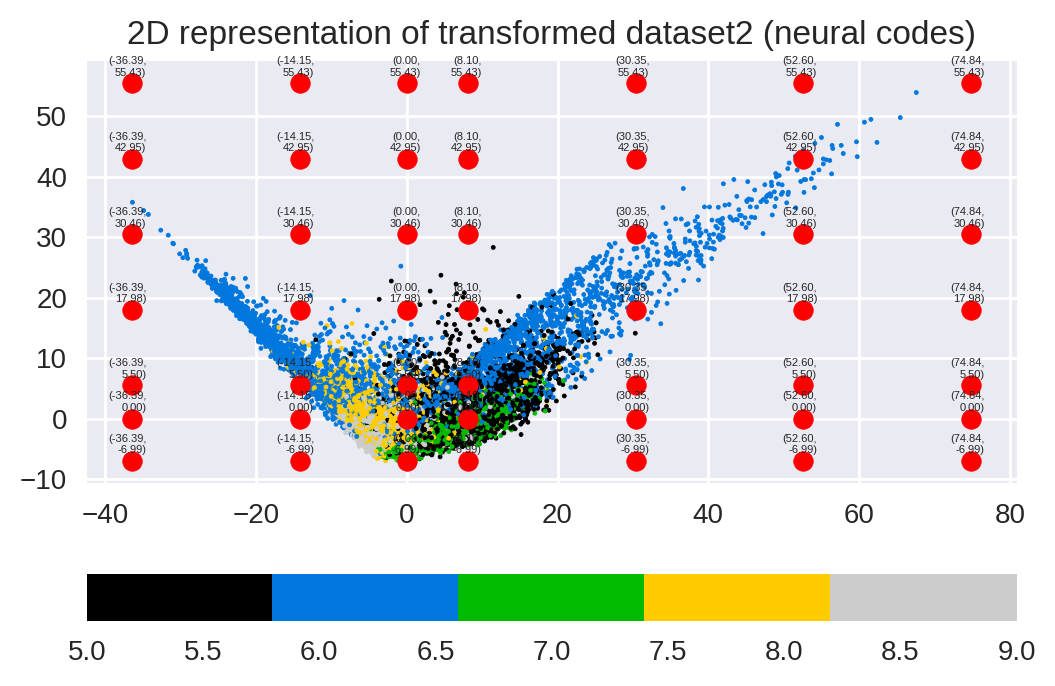

In [32]:
# Make a 2-dimensional scatter plot of the transformed data

def get_grid(component1, component2, n_samples = 5):
    # In axis 1...
    max_c1 = component1.max()
    min_c1 = component1.min()
    lambda_1 = list(np.linspace(min_c1, max_c1, n_samples - 1))
    lambda_1.append(0) # Add center
    # In axis 2...
    max_c2 = component2.max()
    min_c2 = component2.min()
    
    lambda_2 = list(np.linspace(min_c2, max_c2, n_samples - 1))
    lambda_2.append(0) # Add center
    
    return np.asarray([(x,y) for x in sorted(lambda_1) for y in sorted(lambda_2)])


fig,ax = plt.subplots()
fig.set_size_inches(6, 4)
a = plt.title("2D representation of transformed dataset2 (neural codes)")
sc = plt.scatter(pca_projected[:,0], pca_projected[:,1], s = 2, 
                 c = np.argmax(y_dataset2, axis = 1), 
                 cmap = plt.cm.get_cmap('spectral', 5))
plt.colorbar(orientation='horizontal')

grid = get_grid(pca_projected[:, 0], pca_projected[:, 1], 7)

plt.scatter(grid[:, 0], grid[:, 1], c = 'r', label = grid) 

for point in grid:
    plt.annotate("({:.2f},\n{:.2f})".format(point[0], point[1]),
                 xy = (point[0], point[1]),
                 xytext = (5, 2), size = 4,
                 textcoords = 'offset points',
                 ha = 'right',
                 va = 'bottom')

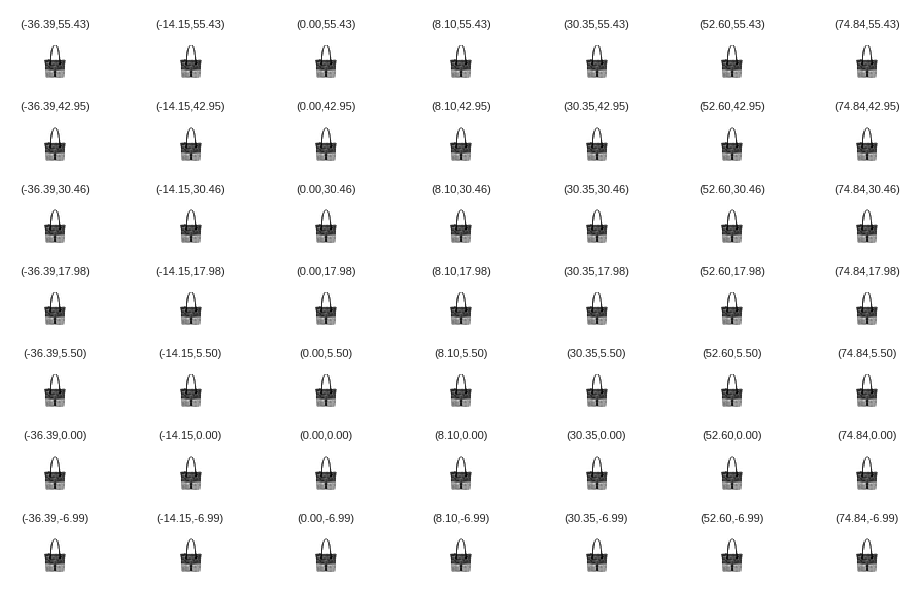

In [27]:
fig, axes = plt.subplots(nrows = 7, ncols = 7)
axes = np.flip(axes.T, axis = 1).flatten()
fig.tight_layout()

for i, point in enumerate(grid):
    coordinate = [point[0], point[1]]

    # Compute the formula
    res = mean_neural_code.flatten() + coordinate[0]*principal_components[0] + coordinate[1]*principal_components[1]
    
    index_neighbor = get_closest_neighbor(res)
    real_img = dataset_2[index_mean_neighbor].reshape((28, 28))
    
    t = axes[i].imshow(real_img, cmap = 'gray_r')
    t = axes[i].set_title("({:.2f},{:.2f})".format(coordinate[0], coordinate[1]),
                      fontsize = 4)
    t = axes[i].get_xaxis().set_visible(False)
    t = axes[i].get_yaxis().set_visible(False)
    fig.tight_layout()

**Compare the results of this analysis with the results of the analysis in part one where you worked on the data in the high dimensional (image) space.**

Note: The colors in the legend of the plot should be read in reverse order (e.g. blue is class 8: 'bag')

In this analyzis a grid of 7x7 has been selected to point out the relevant facts. It is important to note that because of the stochastic nature of the NN, different results can be obtained when re-running this code, but the main analysis holds true.

For this approach, we can clearly notice that there is one class that is described better in the components (in blue), this is the bag class. Indeed, one can observe that the first component is an ankle boot and the second one is the bag - clearly, in both the x-axis and the y-axis, the predominant class is the bag. It may be possible to obtain more diverse results if we focus in values close to the center, where the pca projection is more diverse.

It comes evident that this is a completely different result than the one obtained in the assignment 1. This can be explained by the fact that the neural_codes are the "features learned" by the Neural Network to distinguish the information in the dataset 1, then, we are just mapping the dataset 2 into these embeddings but it may be the case that they are not sufficient to correctly generalize to the dataset 2. Indeed, bag and shoes are the classes not present in the first 5 classes of the Fashion MNIST dataset and hence one could expect such behaviour since their features are different than what was learned and consequently PCA "considers" them as the most relevant information, which proves a bad generalization.


### d) Analyze a cluster computed by k-means (2 Points)
- Run k-means on neural code from Dataset 2 with k=5 using k-means++ and random_state=0
- Compute and show a confusion matrix of the clusters with respect to the original labels.

In [0]:
# Run k-means on neural code from Dataset 2 with k = 5 using k-means++ and 
#   random_state=0

# Method for initialization, defaults to ‘k-means++’ (from doc)
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(neural_codes)

In [29]:
# Compute and show a confusion matrix of the clusters with respect to the 
#   original labels.

y_pred = kmeans.labels_ + 5
y_true = np.argmax(y_dataset2, axis = 1)
cf_matrix = confusion_matrix(y_true, y_pred)

labels = [fmnist_classes.get(5), fmnist_classes.get(6), fmnist_classes.get(7), 
          fmnist_classes.get(8), fmnist_classes.get(9)]

pd.DataFrame(cf_matrix, index = labels, columns = range(5))

,0,1,2,3,4
Sandal,3960,971,8,2045,16
Shirt,446,1733,3140,643,1038
Sneaker,4617,1493,0,890,0
Bag,1485,5009,285,218,3
Ankle boot,1410,5421,1,168,0


**Analysis**

One can observe that there is always dominant classes in the clusters but these capture better the differences. For instance, in cluster 0 the main class is the sneaker, in cluster 1 the ankle boot together with the bag, in 2 and 4 the shirt and in 3 the sandal. It comes interesting to note that the ankle boots and the bags (which arePCA components) get together in the same cluster, which was expected since these are the "outliers" of the dataset (previously unseen information).